In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse

In [79]:
df = pd.read_csv("Exam_Score_Prediction.csv")
df.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [81]:
df.shape

(20000, 13)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


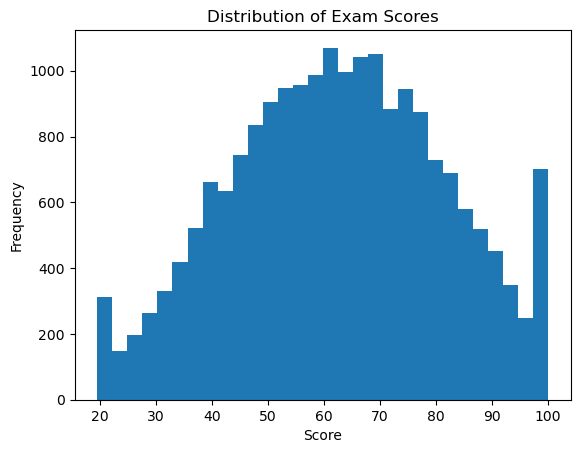

In [85]:
plt.figure()
plt.hist(df["exam_score"], bins=30)
plt.title("Distribution of Exam Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

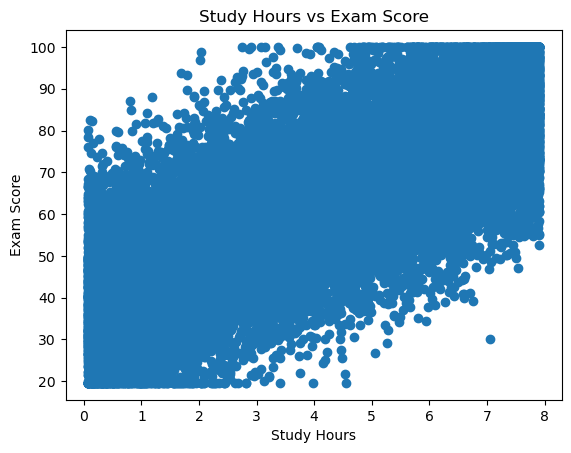

In [87]:
plt.figure()
plt.scatter(df["study_hours"], df["exam_score"])
plt.xlabel("Study Hours")
plt.ylabel("Exam Score")
plt.title("Study Hours vs Exam Score")
plt.show()

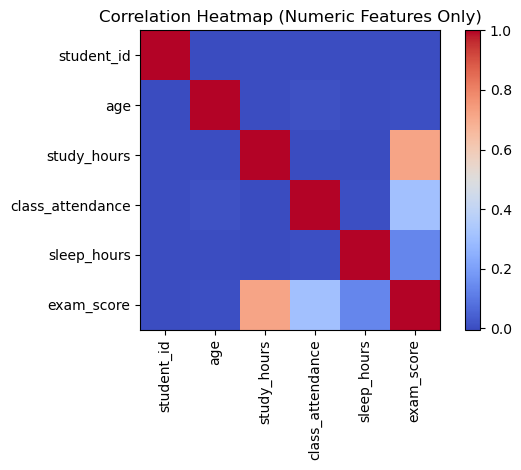

In [89]:
plt.figure()
numeric_df = df.select_dtypes(include=[np.number])
plt.imshow(numeric_df.corr(), cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(numeric_df.columns)), numeric_df.columns, rotation=90)
plt.yticks(range(len(numeric_df.columns)), numeric_df.columns)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.tight_layout()
plt.show()

In [91]:
df = df.drop("student_id", axis=1)

In [93]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.shape

(20000, 24)

In [95]:
X = df_encoded.drop("exam_score", axis=1).astype(float).values
y = df_encoded["exam_score"].astype(float).values.reshape(-1, 1)

In [97]:
from sklearn.model_selection import train_test_split

X_trn, X_tst, y_trn, y_tst = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [99]:
class Standardize():
    """ Standize data based on mean and STD computed using training data

        Attributes:
            mean: Vector of means for each feature 

            std: Vector of STDs for each feature
            
    """
    def __init__(self):
        self.mean: np.ndarray = None
        self.std: np.ndarray = None
    
    def fit(self, X: np.ndarray) -> object:
        """ Computes the mean and std using the training data.

            Args:
                X: training data given as a matrix

            Return:
                Reference to object's instance
        """
        # TODO 4.1
        self.mean = None
        self.std = None
        ### BEGIN SOLUTION
        self.mean = np.mean(X,axis=0)
        self.std = np.std(X,axis=0)
        ### END SOLUTION
        return self
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        """ Transforms the passed data using standardization based on the 
            precomputed mean and STD.

            Args:
                X: Data given as a matrix

            Returns:
                Standardized matrix of data
        """
        # TODO 4.2
        ### BEGIN SOLUTION
        standardized = (X-self.mean)/self.std
        return standardized
        ### END SOLUTION

In [101]:
scaler = Standardize()
scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_tst = scaler.transform(X_tst)

In [103]:
Xb_trn = np.c_[np.ones(len(X_trn)), X_trn]
Xb_tst = np.c_[np.ones(len(X_tst)), X_tst]

In [105]:
theta_lr = np.linalg.inv(Xb_trn.T @ Xb_trn) @ Xb_trn.T @ y_trn

In [107]:
y_pred_lr = Xb_tst @ theta_lr

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_lr = mean_absolute_error(y_tst, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_tst, y_pred_lr))
r2_lr = r2_score(y_tst, y_pred_lr)

mae_lr, rmse_lr, r2_lr

(7.863070298665214, 9.772517380338874, 0.7330084088180805)

In [111]:
y_pred_train_lr = Xb_trn @ theta_lr
train_mse_lr = mean_squared_error(y_trn, y_pred_train_lr)

y_pred_test_lr = y_pred_lr
test_mse_lr = mean_squared_error(y_tst, y_pred_test_lr)

train_mse_lr, test_mse_lr

(95.81240798642696, 95.50209594902536)

In [113]:
from typing import List

def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indices
        
        Args:
            data_len: Length of the data or number of data samples 
                in the data. This is used to generate the indices of
                the data.
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.

        Returns:
            A list of NumPy array's holding the indices of batches
    """
    # TODO 6.1
    indices = None 
    ### BEGIN SOLUTION
    indices = np.arange(data_len)
    ### END SOLUTION

    # TODO 6.2
    ### BEGIN SOLUTION
    np.random.shuffle(indices)
    ### END SOLUTION

    # TODO 6.3
    batches = []
    ### BEGIN SOLUTION
    for i in range(0, data_len, batch_size):
        batch = indices[i:i + batch_size]
        batches.append(batch)
    ### END SOLUTION

    return batches

In [115]:
class LeastMeanSquares():
    """ Performs regression using least mean squares (gradient descent)
    
        Attributes:

            alpha: learning rate or step size
                
            batch_size: Size of mini-batches for mini-batch gradient
                descent.
            
            epochs: Number of epochs to run for mini-batch
                gradient descent
                
            seed: Seed to be used for NumPy's RandomState class
                or universal seed np.random.seed() function.

            w: 2D weight matrix with shape (M, K) where M is the number 
                of features and K is the number of output variables

            trn_error: Stores the training error for each epoch.
    """

    def __init__(
        self, 
        alpha: float ,
        batch_size: int,
        seed: int = 0,
        epochs: int = 1,
    ):
        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.w: np.ndarray = None
        self.trn_error: list = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> object:
        """ Train LMS to learn weights

            Args:
                X: Training data given as a matrix

                y: Training labels given as a 2D column vector
                
            Returns:
                The class's own object reference. 
        """
        # Set seed for reproducibility
        np.random.seed(self.seed)
        # Track training error
        self.trn_error = []
        
            # TODO 7.1
        self.w = None
        ### BEGIN SOLUTION
        M = X.shape[1] 
        if y.ndim > 1:
            K = y.shape[1]
        else:
            K = 1
        self.w = np.random.rand(M, K)

        ### END SOLUTION
        
        # Loop over training epochs
        for e in range(self.epochs):
            # TODO 7.2
            batches = []
            ### BEGIN SOLUTION
            batches = get_batches(len(X), self.batch_size)
            ### END SOLUTION
            # Loop over batched data indices
            for b in batches:
                # TODO 7.3
                mean_grad = None
                ### BEGIN SOLUTION
                X_b = X[b]                     
                y_b = y[b]            
                B = X_b.shape[0] 
                mean_grad = (1 / B) * X_b.T @ (X_b @ self.w - y_b)

                ### END SOLUTION

                # TODO 7.4
                ### BEGIN SOLUTION
                self.w = self.w - self.alpha * mean_grad
                ### END SOLUTION

            # Compute training error for current epoch
            preds = self.predict(X)
            trn_error = rmse(y, preds)
            self.trn_error.append(trn_error)
            
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Data given as a matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
         # TODO 7.5
        ### BEGIN SOLUTION
        return X @ self.w
        ### END SOLUTION

In [117]:
X_trn_lms = np.c_[np.ones(len(X_trn)), X_trn]
X_tst_lms = np.c_[np.ones(len(X_tst)), X_tst]

In [147]:
lms = LeastMeanSquares(
    alpha=0.001,    
    batch_size=128,
    epochs=5000,   
    seed=0
)

lms.fit(X_trn_lms, y_trn)


In [143]:
y_pred_lms = lms.predict(X_tst_lms)

In [145]:
mae_lms = mean_absolute_error(y_tst, y_pred_lms)
rmse_lms = np.sqrt(mean_squared_error(y_tst, y_pred_lms))
r2_lms = r2_score(y_tst, y_pred_lms)

mae_lms, rmse_lms, r2_lms


(7.86307507125357, 9.772513823682342, 0.7330086031584284)

In [127]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "LMS Gradient Descent"],
    "MAE": [mae_lr, mae_lms],
    "RMSE": [rmse_lr, rmse_lms],
    "R2": [r2_lr, r2_lms]
})

results


,Model,MAE,RMSE,R2
0,Linear Regression,7.863070,9.772517,0.733008
1,LMS Gradient Descent,7.863071,9.772519,0.733008


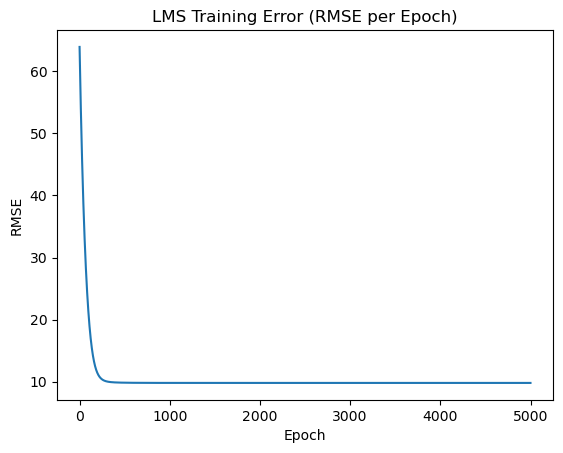

In [129]:
plt.figure()
plt.plot(lms.trn_error)
plt.title("LMS Training Error (RMSE per Epoch)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.show()


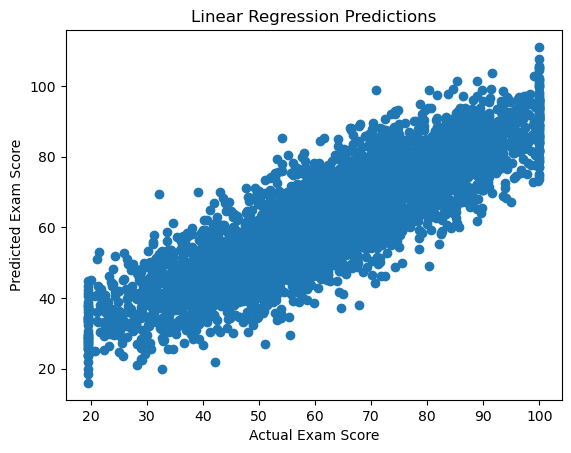

In [131]:
plt.figure()
plt.scatter(y_tst, y_pred_lr)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Linear Regression Predictions")
plt.show()


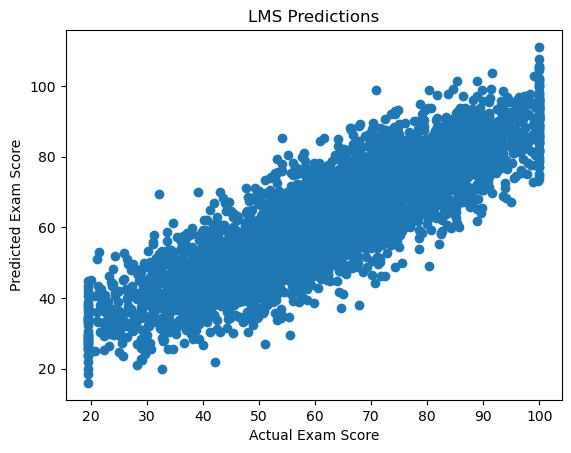

In [133]:
plt.figure()
plt.scatter(y_tst, y_pred_lms)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("LMS Predictions")
plt.show()


In [135]:
print("LINEAR REGRESSION")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R2:", r2_lr)

print("\nLMS GRADIENT DESCENT")
print("MAE:", mae_lms)
print("RMSE:", rmse_lms)
print("R2:", r2_lms)


LINEAR REGRESSION
MAE: 7.863070298665214
RMSE: 9.772517380338874
R2: 0.7330084088180805

LMS GRADIENT DESCENT
MAE: 7.863070822643294
RMSE: 9.772518640627926
R2: 0.7330083399542273


In [137]:
y_pred_train_lms = lms.predict(X_trn_lms)
y_pred_test_lms  = lms.predict(X_tst_lms)


In [139]:
from sklearn.metrics import mean_squared_error

train_mse_lms = mean_squared_error(y_trn, y_pred_train_lms)
test_mse_lms  = mean_squared_error(y_tst, y_pred_test_lms)

train_mse_lms, test_mse_lms

(95.8124080083539, 95.50212058142029)